## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [1]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

C:\Users\ladwi\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cuda:5


In [3]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [4]:
data_df = pd.read_csv("./../02_training/all_data_lake_modeling_in_time.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of          depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0            1     -2.989824     551.514698   -19.194445     -28.116538   
1            2     -2.989824     551.514698   -19.194445     -28.116538   
2            3     -2.989824     551.514698   -19.194445     -28.116538   
3            4     -2.989824     551.514698   -19.194445     -28.116538   
4            5     -2.989824     551.514698   -19.194445     -28.116538   
...        ...           ...            ...          ...            ...   
2628545     46    -12.920028     494.226632   -46.982710     -95.220702   
2628546     47    -12.920028     494.226632   -46.982710     -95.220702   
2628547     48    -12.920028     494.226632   -46.982710     -95.220702   
2628548     49    -12.920028     494.226632   -46.982710     -95.220702   
2628549     50    -12.920028     494.226632   -46.982710     -95.220702   

         Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  \
0   

In [5]:
training_frac = 0.60
depth_steps = 50
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 52571
Number of training points: 1577100


# Normalizing Data

In [6]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [7]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_conv04']]

# Loading Models

In [8]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 'Uw',
                 'day_of_year', 'time_of_day'] #,  
               #  'buoyancy', 'diffusivity', 'temp_initial00', 
               # 'temp_heat01', 'temp_diff02', 'temp_total05',
               # 'ice', 'snow', 'snowice'
m0_output_columns =['temp_conv04']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./../02_training/saved_models/direct_model_train_time.pth"
m0_layers = [len(m0_input_columns), 32, 32,32,32,32,32,32,32,32,32, len(m0_output_columns)]

direct_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
direct_model.load_state_dict(m0_checkpoint)
direct_model = direct_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

## Mixing Model

# Convection Model

# Ice Model

In [9]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [10]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [11]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [12]:
# Create data set
batch_size = 1000

#assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [13]:
print(train_data.shape)
print(test_data.shape)

(1577100, 45)
(1051450, 45)


In [14]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [15]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [16]:
def get_rollout_predictions(direct_model, loader, plot = True):    
    direct_model.eval()

    mean = torch.tensor(train_mean[m0_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m0_output_column_ix]).float().to(device)


#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        y_true = x[:, m0_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m0_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [17]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='Spectral_r', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [18]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.9203031
RMSE of after m0 0.923017
RMSE of after m0 0.60305816
RMSE of after m0 0.65468293
RMSE of after m0 0.6978185
RMSE of after m0 0.69287384
RMSE of after m0 0.35803467
RMSE of after m0 0.17630701
RMSE of after m0 0.25204203
RMSE of after m0 0.41033605
RMSE of after m0 0.36153394
RMSE of after m0 0.5197889
RMSE of after m0 0.365744
RMSE of after m0 0.25976434
RMSE of after m0 0.45003405
RMSE of after m0 0.5324197
RMSE of after m0 0.63843167
RMSE of after m0 0.52887595
RMSE of after m0 0.63781387
RMSE of after m0 0.6297639
RMSE of after m0 0.58853805
RMSE of after m0 0.6559766
RMSE of after m0 0.6495088
RMSE of after m0 0.71511924
RMSE of after m0 0.64261943
RMSE of after m0 0.62503517
RMSE of after m0 0.64106405
RMSE of after m0 0.5810986
RMSE of after m0 0.5874589
RMSE of after m0 0.50612324
RMSE of after m0 0.43213183
RMSE of after m0 0.47265637
RMSE of after m0 0.46916407
RMSE of after m0 0.48589417
RMSE of after m0 0.54853815
RMSE of after m0 0.5749688
RMSE o

RMSE of after m0 0.585632
RMSE of after m0 0.572332
RMSE of after m0 0.5454684
RMSE of after m0 0.48810956
RMSE of after m0 0.44656745
RMSE of after m0 0.78379977
RMSE of after m0 0.9576856
RMSE of after m0 0.82580054
RMSE of after m0 0.40819067
RMSE of after m0 0.5639321
RMSE of after m0 0.38496077
RMSE of after m0 0.44565436
RMSE of after m0 1.0756116
RMSE of after m0 0.41687804
RMSE of after m0 0.7227999
RMSE of after m0 0.38089764
RMSE of after m0 1.1740186
RMSE of after m0 0.44422153
RMSE of after m0 0.51417667
RMSE of after m0 0.34828568
RMSE of after m0 0.40746674
RMSE of after m0 0.4792895
RMSE of after m0 0.51880735
RMSE of after m0 0.7604677
RMSE of after m0 0.56504124
RMSE of after m0 0.4621133
RMSE of after m0 0.5353068
RMSE of after m0 0.5765943
RMSE of after m0 0.5903788
RMSE of after m0 1.0360923
RMSE of after m0 0.57391036
RMSE of after m0 0.36635256
RMSE of after m0 0.61307037
RMSE of after m0 0.42790183
RMSE of after m0 0.8616144
RMSE of after m0 1.0626763
RMSE of aft

RMSE of after m0 0.50261796
RMSE of after m0 0.5432734
RMSE of after m0 0.6018943
RMSE of after m0 0.4618442
RMSE of after m0 0.5282993
RMSE of after m0 0.45533186
RMSE of after m0 0.8790693
RMSE of after m0 1.1102513
RMSE of after m0 0.69420457
RMSE of after m0 0.51494277
RMSE of after m0 0.6129471
RMSE of after m0 0.6036468
RMSE of after m0 0.83708775
RMSE of after m0 0.84005773
RMSE of after m0 0.95310533
RMSE of after m0 0.64036316
RMSE of after m0 0.5323878
RMSE of after m0 0.48279607
RMSE of after m0 0.48177025
RMSE of after m0 0.5184325
RMSE of after m0 0.7396446
RMSE of after m0 0.5060778
RMSE of after m0 0.42016816
RMSE of after m0 0.49057463
RMSE of after m0 0.6907876
RMSE of after m0 0.8928609
RMSE of after m0 0.9364242
RMSE of after m0 0.605091
RMSE of after m0 0.63065684
RMSE of after m0 0.6317133
RMSE of after m0 0.57049
RMSE of after m0 0.813275
RMSE of after m0 0.62498397
RMSE of after m0 0.67658645
RMSE of after m0 0.79385006
RMSE of after m0 0.6096758
RMSE of after m0

RMSE of after m0 0.07838866
RMSE of after m0 0.084012456
RMSE of after m0 0.12708998
RMSE of after m0 0.08965424
RMSE of after m0 0.055453762
RMSE of after m0 0.10115818
RMSE of after m0 0.086620696
RMSE of after m0 0.19796182
RMSE of after m0 0.22933145
RMSE of after m0 0.3076501
RMSE of after m0 0.41591504
RMSE of after m0 0.42257446
RMSE of after m0 0.17562658
RMSE of after m0 0.059735958
RMSE of after m0 0.06887103
RMSE of after m0 0.05137129
RMSE of after m0 0.05314606
RMSE of after m0 0.101762705
RMSE of after m0 0.07801291
RMSE of after m0 0.06901698
RMSE of after m0 0.08212396
RMSE of after m0 0.1176491
RMSE of after m0 0.05444404
RMSE of after m0 0.10985969
RMSE of after m0 0.14188924
RMSE of after m0 0.0842736
RMSE of after m0 0.090372965
RMSE of after m0 0.07435525
RMSE of after m0 0.07533277
RMSE of after m0 0.1982689
RMSE of after m0 0.09062684
RMSE of after m0 0.19193989
RMSE of after m0 0.15878983
RMSE of after m0 0.13462944
RMSE of after m0 0.22175838
RMSE of after m0 0

RMSE of after m0 0.5650418
RMSE of after m0 0.6901155
RMSE of after m0 0.4871166
RMSE of after m0 0.34109926
RMSE of after m0 0.43357715
RMSE of after m0 0.6652721
RMSE of after m0 0.37417427
RMSE of after m0 0.8416426
RMSE of after m0 0.5311193
RMSE of after m0 0.49274966
RMSE of after m0 0.5257025
RMSE of after m0 0.4565574
RMSE of after m0 0.69503105
RMSE of after m0 0.49356383
RMSE of after m0 1.0111816
RMSE of after m0 0.4661152
RMSE of after m0 0.7224032
RMSE of after m0 0.72118825
RMSE of after m0 0.43353873
RMSE of after m0 0.8633812
RMSE of after m0 0.47843957
RMSE of after m0 0.34898323
RMSE of after m0 0.4874387
RMSE of after m0 0.48218423
RMSE of after m0 0.16128594
RMSE of after m0 0.32632548
RMSE of after m0 0.18613058
RMSE of after m0 0.21296571
RMSE of after m0 0.3350403
RMSE of after m0 0.18146342
RMSE of after m0 0.1865551
RMSE of after m0 0.13022602
RMSE of after m0 0.22534674
RMSE of after m0 0.16604489
RMSE of after m0 0.2206157
RMSE of after m0 0.09355399
RMSE of 

RMSE of after m0 0.5534462
RMSE of after m0 0.55877715
RMSE of after m0 0.8593785
RMSE of after m0 0.6458957
RMSE of after m0 0.5468958
RMSE of after m0 0.44838902
RMSE of after m0 0.67692006
RMSE of after m0 0.71314806
RMSE of after m0 0.6724977
RMSE of after m0 0.8409688
RMSE of after m0 0.4625555
RMSE of after m0 0.53856844
RMSE of after m0 0.60787493
RMSE of after m0 0.5624817
RMSE of after m0 0.6637038
RMSE of after m0 0.76713353
RMSE of after m0 1.2151555
RMSE of after m0 1.1962107
RMSE of after m0 1.1659844
RMSE of after m0 0.81431705
RMSE of after m0 0.8065527
RMSE of after m0 1.1350236
RMSE of after m0 1.1486647
RMSE of after m0 1.4039266
RMSE of after m0 1.406837
RMSE of after m0 1.0820335
RMSE of after m0 0.7193598
RMSE of after m0 0.67976856
RMSE of after m0 0.7930333
RMSE of after m0 0.7409824
RMSE of after m0 1.0263226
RMSE of after m0 0.7412998
RMSE of after m0 0.7661253
RMSE of after m0 0.592947
RMSE of after m0 0.93145466
RMSE of after m0 1.2094878
RMSE of after m0 0.7

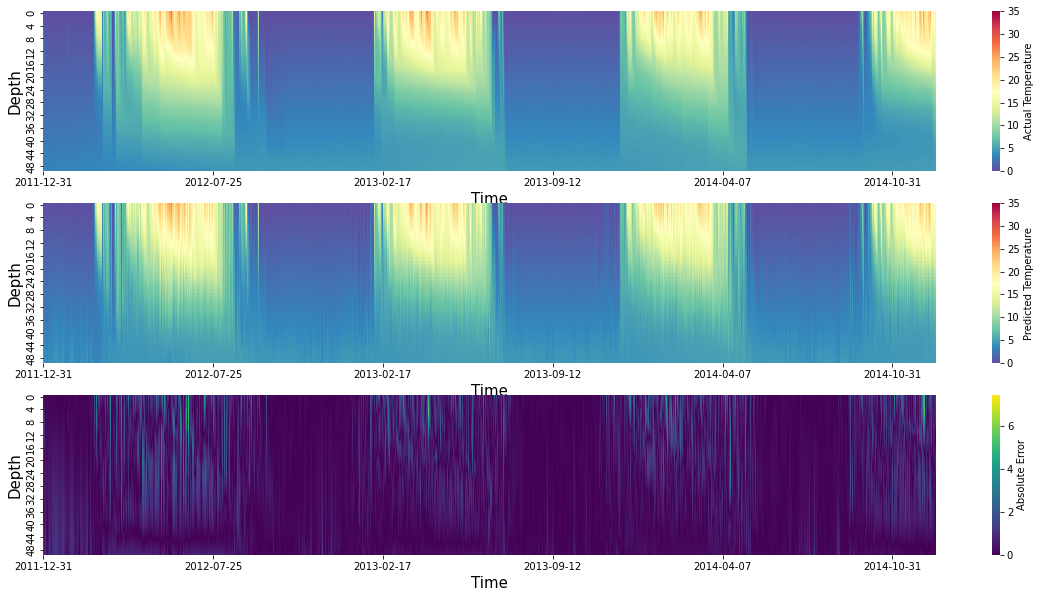

In [19]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

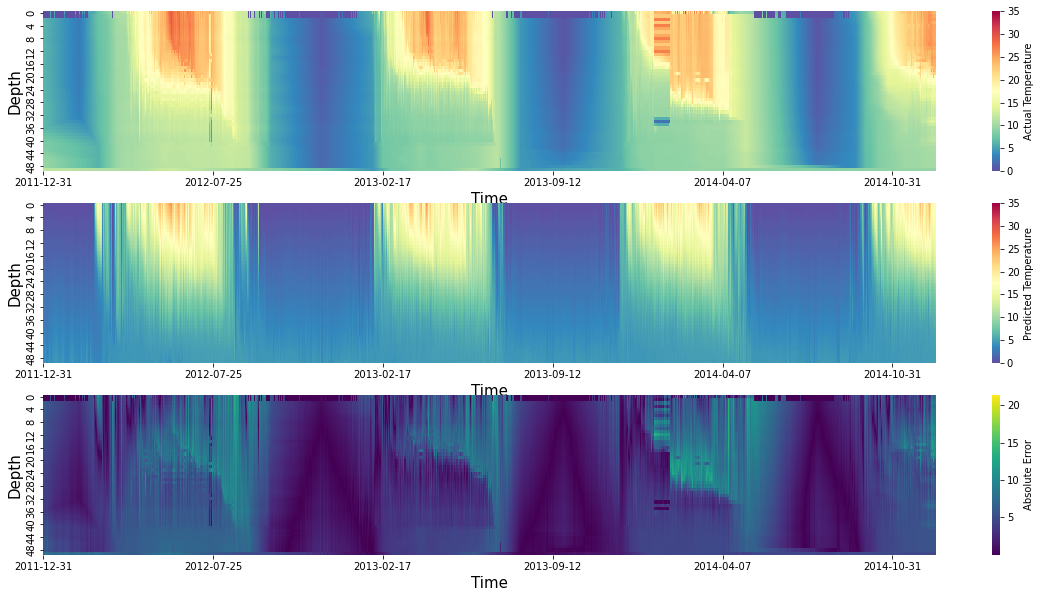

In [20]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [21]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.45474413
RMSE of after m0 1.5418825
RMSE of after m0 0.5798853
RMSE of after m0 0.8430067
RMSE of after m0 0.93725216
RMSE of after m0 1.1967512
RMSE of after m0 1.0330642
RMSE of after m0 0.87835854
RMSE of after m0 1.0676184
RMSE of after m0 0.7360261
RMSE of after m0 1.2489486
RMSE of after m0 1.5379933
RMSE of after m0 1.3682712
RMSE of after m0 1.5781529
RMSE of after m0 1.7608097
RMSE of after m0 1.536262
RMSE of after m0 1.1827118
RMSE of after m0 1.0957853
RMSE of after m0 1.026282
RMSE of after m0 0.8774736
RMSE of after m0 1.0797982
RMSE of after m0 1.099399
RMSE of after m0 1.8416457
RMSE of after m0 3.154782
RMSE of after m0 2.9662132
RMSE of after m0 2.9057035
RMSE of after m0 3.1640756
RMSE of after m0 2.5925055
RMSE of after m0 2.2796519
RMSE of after m0 2.0887337
RMSE of after m0 2.321252
RMSE of after m0 2.4157686
RMSE of after m0 2.1191723
RMSE of after m0 1.8260474
RMSE of after m0 1.7562672
RMSE of after m0 1.8954076
RMSE of after m0 1.7114471
RMS

RMSE of after m0 1.1580708
RMSE of after m0 1.319821
RMSE of after m0 2.0062618
RMSE of after m0 1.5892922
RMSE of after m0 1.1428078
RMSE of after m0 1.3400171
RMSE of after m0 1.146824
RMSE of after m0 1.0420289
RMSE of after m0 1.783227
RMSE of after m0 2.1021004
RMSE of after m0 1.8049579
RMSE of after m0 1.4427794
RMSE of after m0 1.2976396
RMSE of after m0 1.0901041
RMSE of after m0 1.8151399
RMSE of after m0 1.497212
RMSE of after m0 1.1021272
RMSE of after m0 1.3890618
RMSE of after m0 1.3861873
RMSE of after m0 1.4502423
RMSE of after m0 2.2825856
RMSE of after m0 2.3716593
RMSE of after m0 2.4929452
RMSE of after m0 1.9946033
RMSE of after m0 1.8982906
RMSE of after m0 1.3971751
RMSE of after m0 1.478189
RMSE of after m0 1.6043266
RMSE of after m0 2.02673
RMSE of after m0 1.9966532
RMSE of after m0 1.5573468
RMSE of after m0 1.2166654
RMSE of after m0 1.9143951
RMSE of after m0 1.522525
RMSE of after m0 2.0200846
RMSE of after m0 2.0444052
RMSE of after m0 1.7450829
RMSE of a

RMSE of after m0 0.43402076
RMSE of after m0 0.2272513
RMSE of after m0 0.21422073
RMSE of after m0 0.28060618
RMSE of after m0 0.24654654
RMSE of after m0 0.20998976
RMSE of after m0 0.13892588
RMSE of after m0 0.19301926
RMSE of after m0 0.29955217
RMSE of after m0 0.31562632
RMSE of after m0 0.060366947
RMSE of after m0 0.057416704
RMSE of after m0 0.07181696
RMSE of after m0 0.11828109
RMSE of after m0 0.26898
RMSE of after m0 0.31735945
RMSE of after m0 0.5221138
RMSE of after m0 0.27501428
RMSE of after m0 0.08367534
RMSE of after m0 0.065169185
RMSE of after m0 0.29143122
RMSE of after m0 0.59448755
RMSE of after m0 0.56083363
RMSE of after m0 0.40639645
RMSE of after m0 0.506017
RMSE of after m0 0.48793384
RMSE of after m0 0.19604929
RMSE of after m0 0.5393726
RMSE of after m0 0.63420284
RMSE of after m0 0.6093153
RMSE of after m0 0.6927489
RMSE of after m0 0.8104296
RMSE of after m0 0.7200817
RMSE of after m0 1.0173593
RMSE of after m0 0.79364675
RMSE of after m0 0.81934774
RM

RMSE of after m0 1.0566227
RMSE of after m0 2.8080046
RMSE of after m0 1.3360672
RMSE of after m0 1.2774093
RMSE of after m0 2.9487822
RMSE of after m0 5.8087525
RMSE of after m0 4.230365
RMSE of after m0 3.1934404
RMSE of after m0 4.0033083
RMSE of after m0 4.8861823
RMSE of after m0 4.3187594
RMSE of after m0 3.6539483
RMSE of after m0 2.4103742
RMSE of after m0 2.0208294
RMSE of after m0 2.968515
RMSE of after m0 2.6918561
RMSE of after m0 2.9496222
RMSE of after m0 3.4076176
RMSE of after m0 3.3803947
RMSE of after m0 4.328634
RMSE of after m0 3.3305533
RMSE of after m0 2.7133894
RMSE of after m0 1.5549254
RMSE of after m0 1.7685664
RMSE of after m0 1.2895833
RMSE of after m0 1.5194666
RMSE of after m0 1.2303696
RMSE of after m0 1.6140826
RMSE of after m0 1.8770801
RMSE of after m0 3.1690054
RMSE of after m0 1.0054626
RMSE of after m0 1.0640552
RMSE of after m0 2.6536772
RMSE of after m0 0.77551216
RMSE of after m0 0.38614357
RMSE of after m0 1.0086817
RMSE of after m0 1.8667942
RM

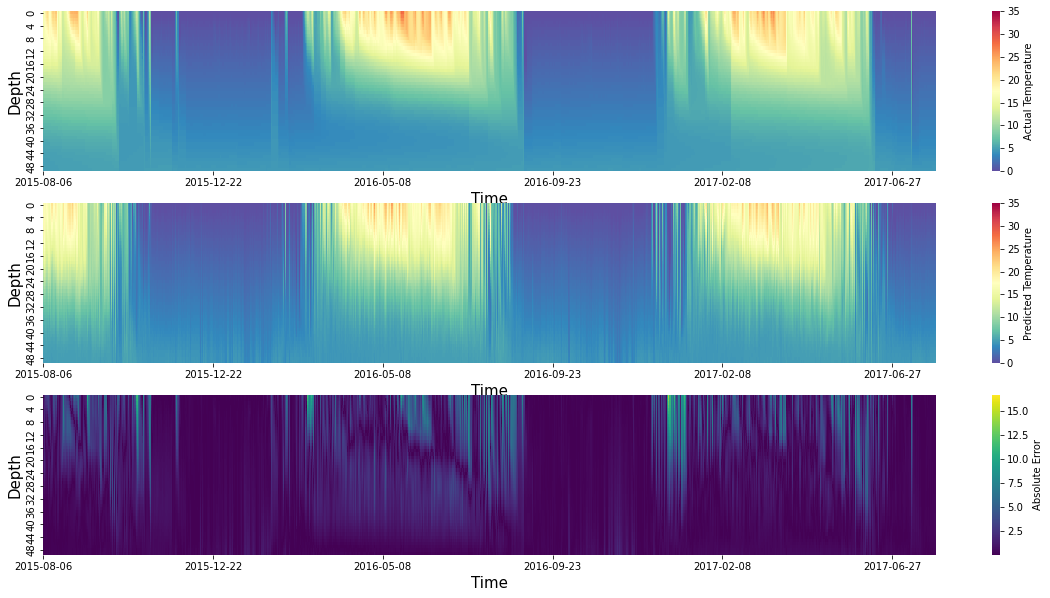

In [22]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

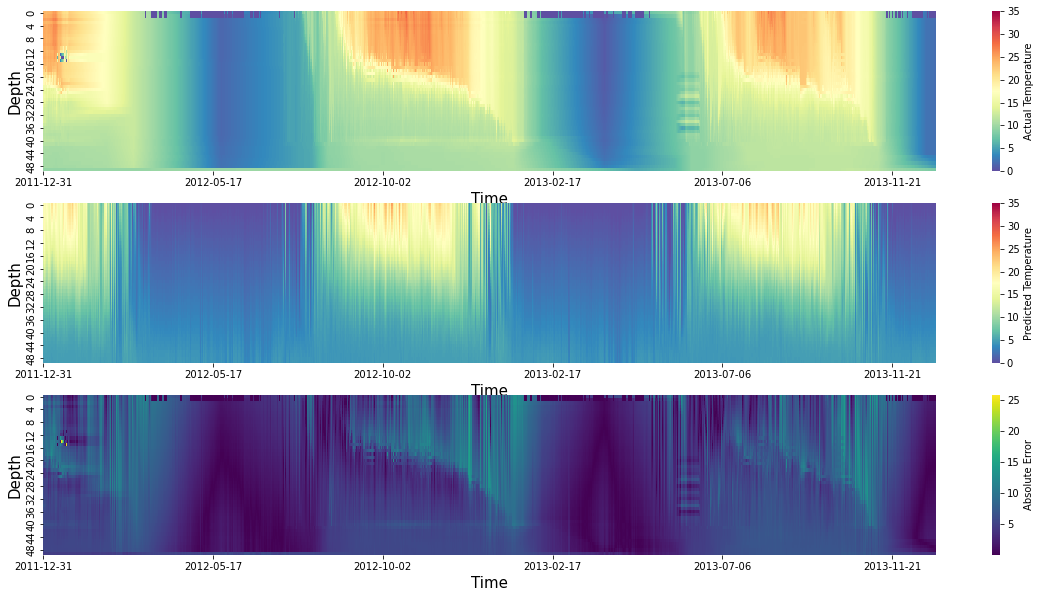

In [23]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [24]:
train_rmse, train_l2_err = compute_metrics( direct_model, train_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(direct_model, test_loader, m0_input_column_ix, m0_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.5865786715949166, Train L2 Error: 0.0772480167621377
Test RMSE: 1.8741866785985166, Train L2 Error: 0.2356265960366856


## Mixing Model

## Convection Model

## Ice Model

# Finetuning

In [25]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(direct_model.parameters()) 
optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [26]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [27]:
#freeze_model(heating_model)

unfreeze_model(direct_model)


# Finetuning on Observed Temperature

In [28]:
direct_model.train()


n_epochs = 1000

# mean and standard dev of "temp_total04" of model 4 output
mean_out0 = torch.tensor(train_mean[m0_output_column_ix[0]]).float().to(device)
std_out0 = torch.tensor(train_std[m0_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input

train_loss = []
LOSS_m0 = []


for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0

    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = direct_model(m0_input) #predicts diff and temp
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out0)/std_out0
        
        loss_m0 = criterion(m0_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m0
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()

    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)

    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)

    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/1000 [00:21<5:52:19, 21.16s/it]

Epoch : 0, Train_loss: 0.6827155895087353, Loss m0: 0.6827155895087353


  5%|▌         | 51/1000 [18:10<5:36:42, 21.29s/it]

Epoch : 50, Train_loss: 0.11282835632718448, Loss m0: 0.11282835632718448


 10%|█         | 101/1000 [35:54<5:21:24, 21.45s/it]

Epoch : 100, Train_loss: 0.10215777885041899, Loss m0: 0.10215777885041899


 15%|█▌        | 151/1000 [53:33<4:58:29, 21.10s/it]

Epoch : 150, Train_loss: 0.09787163957723279, Loss m0: 0.09787163957723279


 20%|██        | 201/1000 [1:11:16<4:41:13, 21.12s/it]

Epoch : 200, Train_loss: 0.09532484959212517, Loss m0: 0.09532484959212517


 25%|██▌       | 251/1000 [1:28:58<4:23:34, 21.11s/it]

Epoch : 250, Train_loss: 0.09345872637299946, Loss m0: 0.09345872637299946


 30%|███       | 301/1000 [1:46:37<4:08:08, 21.30s/it]

Epoch : 300, Train_loss: 0.09196522249161479, Loss m0: 0.09196522249161479


 35%|███▌      | 351/1000 [2:04:18<3:48:44, 21.15s/it]

Epoch : 350, Train_loss: 0.09073832821772589, Loss m0: 0.09073832821772589


 40%|████      | 401/1000 [2:21:57<3:29:33, 20.99s/it]

Epoch : 400, Train_loss: 0.08970085942630239, Loss m0: 0.08970085942630239


 45%|████▌     | 451/1000 [2:39:36<3:13:30, 21.15s/it]

Epoch : 450, Train_loss: 0.08880208461180669, Loss m0: 0.08880208461180669


 50%|█████     | 501/1000 [2:57:16<2:55:31, 21.11s/it]

Epoch : 500, Train_loss: 0.0880076610928824, Loss m0: 0.0880076610928824


 55%|█████▌    | 551/1000 [3:14:39<2:37:15, 21.01s/it]

Epoch : 550, Train_loss: 0.08730092961181792, Loss m0: 0.08730092961181792


 60%|██████    | 601/1000 [3:32:18<2:19:53, 21.04s/it]

Epoch : 600, Train_loss: 0.08667037071523237, Loss m0: 0.08667037071523237


 65%|██████▌   | 651/1000 [3:49:51<2:02:26, 21.05s/it]

Epoch : 650, Train_loss: 0.08609997300213942, Loss m0: 0.08609997300213942


 70%|███████   | 701/1000 [4:07:29<1:45:19, 21.14s/it]

Epoch : 700, Train_loss: 0.08557533257341671, Loss m0: 0.08557533257341671


 75%|███████▌  | 751/1000 [4:25:02<1:27:28, 21.08s/it]

Epoch : 750, Train_loss: 0.08508816371135962, Loss m0: 0.08508816371135962


 80%|████████  | 801/1000 [4:43:11<1:13:40, 22.21s/it]

Epoch : 800, Train_loss: 0.0846357308698497, Loss m0: 0.0846357308698497


 85%|████████▌ | 851/1000 [5:01:44<55:41, 22.43s/it]  

Epoch : 850, Train_loss: 0.08421461515132153, Loss m0: 0.08421461515132153


 90%|█████████ | 901/1000 [5:20:07<35:03, 21.25s/it]

Epoch : 900, Train_loss: 0.08382029459647673, Loss m0: 0.08382029459647673


 95%|█████████▌| 951/1000 [5:37:50<17:10, 21.04s/it]

Epoch : 950, Train_loss: 0.0834496922540763, Loss m0: 0.0834496922540763


100%|██████████| 1000/1000 [5:55:04<00:00, 21.30s/it]


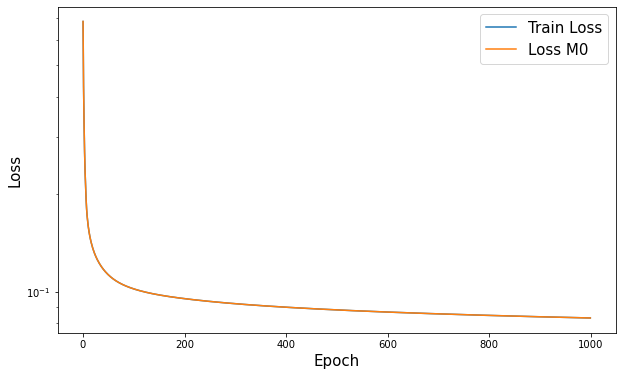

In [29]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")

plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [30]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(direct_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 2.1384254
RMSE of after m0 3.0750527
RMSE of after m0 3.054009
RMSE of after m0 2.2115614
RMSE of after m0 1.7933306
RMSE of after m0 2.357631
RMSE of after m0 3.062418
RMSE of after m0 3.6662467
RMSE of after m0 3.4168751
RMSE of after m0 3.0440464
RMSE of after m0 2.920785
RMSE of after m0 2.4822109
RMSE of after m0 3.4290543
RMSE of after m0 3.3940942
RMSE of after m0 2.4271588
RMSE of after m0 2.0676982
RMSE of after m0 1.886171
RMSE of after m0 1.9442847
RMSE of after m0 1.8569486
RMSE of after m0 1.8792893
RMSE of after m0 1.8874205
RMSE of after m0 1.5243186
RMSE of after m0 1.4975176
RMSE of after m0 1.0713384
RMSE of after m0 1.1178848
RMSE of after m0 1.2785914
RMSE of after m0 1.3353876
RMSE of after m0 1.8291346
RMSE of after m0 1.6101027
RMSE of after m0 1.6421332
RMSE of after m0 1.8133333
RMSE of after m0 1.7042516
RMSE of after m0 1.6974587
RMSE of after m0 1.6658617
RMSE of after m0 1.4129901
RMSE of after m0 1.0910203
RMSE of after m0 1.4489712
RMSE o

RMSE of after m0 8.702202
RMSE of after m0 8.924666
RMSE of after m0 8.934149
RMSE of after m0 8.829108
RMSE of after m0 8.777071
RMSE of after m0 9.001143
RMSE of after m0 8.949214
RMSE of after m0 8.679881
RMSE of after m0 8.532975
RMSE of after m0 8.498327
RMSE of after m0 8.365662
RMSE of after m0 8.156434
RMSE of after m0 8.08293
RMSE of after m0 7.862089
RMSE of after m0 8.370971
RMSE of after m0 9.5134325
RMSE of after m0 9.278318
RMSE of after m0 9.418654
RMSE of after m0 10.572513
RMSE of after m0 9.879492
RMSE of after m0 10.052137
RMSE of after m0 10.173484
RMSE of after m0 9.98352
RMSE of after m0 10.245593
RMSE of after m0 9.420046
RMSE of after m0 8.733013
RMSE of after m0 8.550544
RMSE of after m0 8.116494
RMSE of after m0 7.530692
RMSE of after m0 7.3269925
RMSE of after m0 7.576201
RMSE of after m0 7.6694965
RMSE of after m0 7.6409955
RMSE of after m0 7.5162144
RMSE of after m0 7.558789
RMSE of after m0 7.302433
RMSE of after m0 6.9989715
RMSE of after m0 6.888542
RMSE

RMSE of after m0 3.8868165
RMSE of after m0 4.146601
RMSE of after m0 4.4879694
RMSE of after m0 4.2386537
RMSE of after m0 4.074957
RMSE of after m0 3.792918
RMSE of after m0 4.046235
RMSE of after m0 4.2890844
RMSE of after m0 3.766593
RMSE of after m0 4.0136223
RMSE of after m0 4.1553316
RMSE of after m0 4.0118413
RMSE of after m0 4.2291656
RMSE of after m0 4.38865
RMSE of after m0 4.611219
RMSE of after m0 4.6706915
RMSE of after m0 5.080344
RMSE of after m0 4.6779847
RMSE of after m0 4.5530114
RMSE of after m0 4.41593
RMSE of after m0 4.2076764
RMSE of after m0 4.2550545
RMSE of after m0 4.3204517
RMSE of after m0 4.593226
RMSE of after m0 4.3009777
RMSE of after m0 4.3422666
RMSE of after m0 4.557346
RMSE of after m0 4.7012305
RMSE of after m0 4.965664
RMSE of after m0 5.0481186
RMSE of after m0 4.8741875
RMSE of after m0 4.8257036
RMSE of after m0 4.583957
RMSE of after m0 4.762642
RMSE of after m0 4.6463513
RMSE of after m0 4.6670027
RMSE of after m0 5.0288324
RMSE of after m0 

RMSE of after m0 0.75727075
RMSE of after m0 0.8154968
RMSE of after m0 0.7844111
RMSE of after m0 0.7932689
RMSE of after m0 0.7809806
RMSE of after m0 1.0578338
RMSE of after m0 0.95664036
RMSE of after m0 0.94673294
RMSE of after m0 1.1261691
RMSE of after m0 1.0065458
RMSE of after m0 1.2591498
RMSE of after m0 1.5605342
RMSE of after m0 1.0810792
RMSE of after m0 1.153888
RMSE of after m0 1.1142329
RMSE of after m0 1.1728112
RMSE of after m0 1.3722345
RMSE of after m0 1.5128276
RMSE of after m0 1.4165367
RMSE of after m0 1.3911095
RMSE of after m0 1.7362674
RMSE of after m0 1.4392565
RMSE of after m0 1.2209524
RMSE of after m0 1.326575
RMSE of after m0 1.4391619
RMSE of after m0 1.2821761
RMSE of after m0 2.2264924
RMSE of after m0 2.462283
RMSE of after m0 1.8022324
RMSE of after m0 1.7606076
RMSE of after m0 2.417078
RMSE of after m0 2.345033
RMSE of after m0 2.918919
RMSE of after m0 2.2755008
RMSE of after m0 2.3955648
RMSE of after m0 2.6251001
RMSE of after m0 2.57623
RMSE o

RMSE of after m0 6.3106217
RMSE of after m0 6.8284903
RMSE of after m0 5.146375
RMSE of after m0 5.2832603
RMSE of after m0 5.0449057
RMSE of after m0 4.2809687
RMSE of after m0 4.565371
RMSE of after m0 5.451009
RMSE of after m0 6.3353896
RMSE of after m0 5.6915436
RMSE of after m0 5.8633657
RMSE of after m0 5.8202615
RMSE of after m0 4.7655454
RMSE of after m0 4.40639
RMSE of after m0 5.7834635
RMSE of after m0 4.6529894
RMSE of after m0 3.8842618
RMSE of after m0 4.3109303
RMSE of after m0 5.3920918
RMSE of after m0 5.4104404
RMSE of after m0 4.9994965
RMSE of after m0 4.112224
RMSE of after m0 3.1493814
RMSE of after m0 3.9295003
RMSE of after m0 4.570428
RMSE of after m0 4.302813
RMSE of after m0 2.5493653
RMSE of after m0 2.396721
RMSE of after m0 3.4453676
RMSE of after m0 3.530123
RMSE of after m0 3.1696382
RMSE of after m0 2.951131
RMSE of after m0 3.4305196
RMSE of after m0 3.8320882
RMSE of after m0 4.285252
RMSE of after m0 3.5113585
RMSE of after m0 3.451874
RMSE of after 

Train RMSE Simulated: 4.596591472625732
Train RMSE Observed Temp: 1.4232009649276733
Train L2 Error: 0.40440812706947327
The RMSEs after each modelling stage: [3.99433565 0.         0.         0.         0.        ]


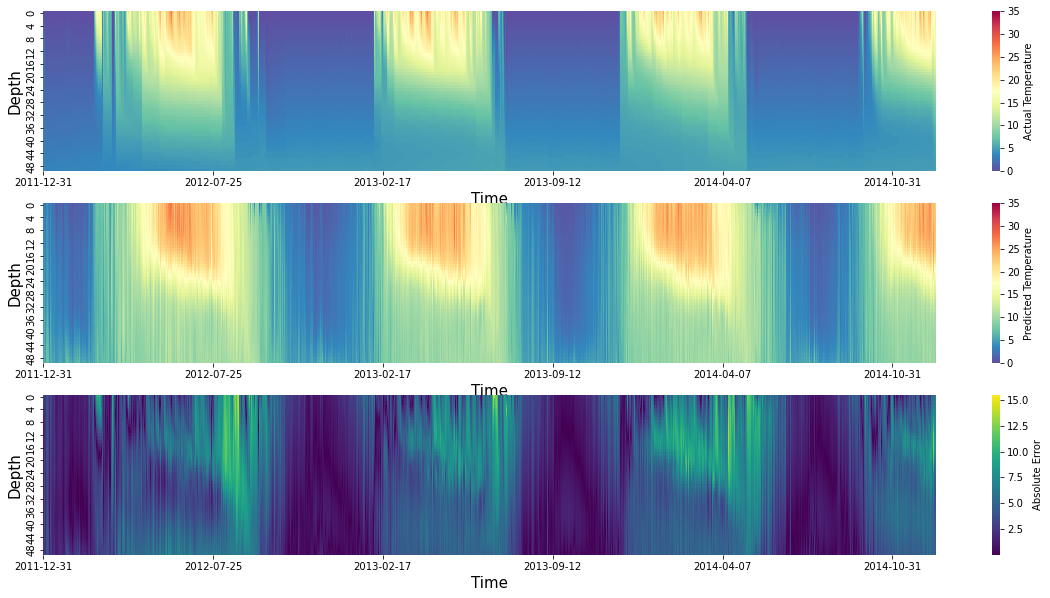

In [31]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

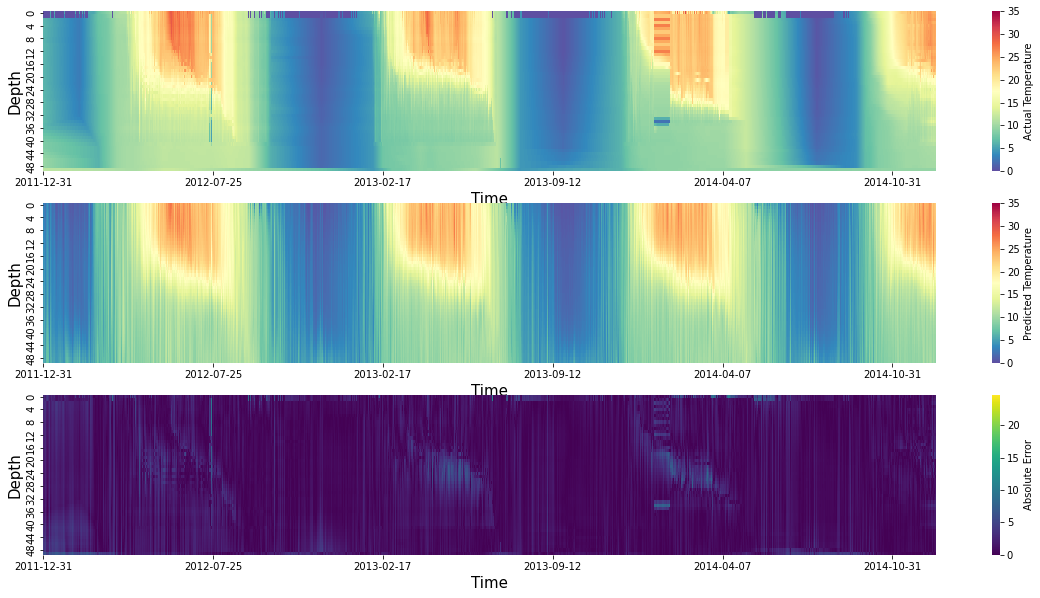

In [32]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [33]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(direct_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 6.208214
RMSE of after m0 6.613217
RMSE of after m0 6.4771566
RMSE of after m0 6.1933455
RMSE of after m0 6.214254
RMSE of after m0 6.332818
RMSE of after m0 6.089961
RMSE of after m0 5.830087
RMSE of after m0 6.329802
RMSE of after m0 6.611796
RMSE of after m0 6.9922585
RMSE of after m0 6.607603
RMSE of after m0 6.018387
RMSE of after m0 5.956855
RMSE of after m0 5.5599847
RMSE of after m0 5.936908
RMSE of after m0 7.023911
RMSE of after m0 6.9765954
RMSE of after m0 7.080054
RMSE of after m0 7.179586
RMSE of after m0 6.959557
RMSE of after m0 7.2675447
RMSE of after m0 8.52545
RMSE of after m0 8.039948
RMSE of after m0 7.9365854
RMSE of after m0 8.158585
RMSE of after m0 8.109085
RMSE of after m0 7.6687894
RMSE of after m0 8.006574
RMSE of after m0 8.155165
RMSE of after m0 7.7610445
RMSE of after m0 6.5806704
RMSE of after m0 5.952181
RMSE of after m0 5.8551035
RMSE of after m0 5.561843
RMSE of after m0 6.0468297
RMSE of after m0 5.390778
RMSE of after m0 5.9460044


RMSE of after m0 4.6072474
RMSE of after m0 4.308119
RMSE of after m0 4.781681
RMSE of after m0 2.9580789
RMSE of after m0 4.3024807
RMSE of after m0 4.3367496
RMSE of after m0 4.289788
RMSE of after m0 4.1265087
RMSE of after m0 4.13465
RMSE of after m0 5.201494
RMSE of after m0 5.55696
RMSE of after m0 5.056147
RMSE of after m0 5.856398
RMSE of after m0 5.565126
RMSE of after m0 5.562924
RMSE of after m0 5.481155
RMSE of after m0 5.683883
RMSE of after m0 5.549808
RMSE of after m0 5.3752675
RMSE of after m0 6.2736964
RMSE of after m0 5.8599315
RMSE of after m0 5.028696
RMSE of after m0 6.1386127
RMSE of after m0 5.2339125
RMSE of after m0 5.237064
RMSE of after m0 5.794315
RMSE of after m0 5.0121617
RMSE of after m0 4.7838755
RMSE of after m0 4.1524053
RMSE of after m0 4.218414
RMSE of after m0 4.613398
RMSE of after m0 5.4502835
RMSE of after m0 5.223092
RMSE of after m0 5.5625896
RMSE of after m0 5.572853
RMSE of after m0 5.565468
RMSE of after m0 5.5228257
RMSE of after m0 5.40300

RMSE of after m0 1.7798699
RMSE of after m0 1.9036005
RMSE of after m0 1.9622381
RMSE of after m0 1.6811618
RMSE of after m0 1.0244266
RMSE of after m0 0.9886349
RMSE of after m0 1.0652258
RMSE of after m0 0.85525227
RMSE of after m0 0.6281482
RMSE of after m0 0.46195292
RMSE of after m0 0.77635765
RMSE of after m0 0.91188514
RMSE of after m0 0.8298557
RMSE of after m0 0.7167581
RMSE of after m0 0.8026403
RMSE of after m0 0.8229052
RMSE of after m0 0.6527065
RMSE of after m0 0.6577599
RMSE of after m0 0.822168
RMSE of after m0 1.1829126
RMSE of after m0 0.79185647
RMSE of after m0 0.8449886
RMSE of after m0 0.97819525
RMSE of after m0 0.74176556
RMSE of after m0 1.2025323
RMSE of after m0 1.1908635
RMSE of after m0 0.8287077
RMSE of after m0 0.9594836
RMSE of after m0 0.71629804
RMSE of after m0 0.67763996
RMSE of after m0 0.83255094
RMSE of after m0 1.0499414
RMSE of after m0 1.0895238
RMSE of after m0 1.0116124
RMSE of after m0 1.7009438
RMSE of after m0 1.3002524
RMSE of after m0 2.

RMSE of after m0 4.828127
RMSE of after m0 4.9915724
RMSE of after m0 4.855942
RMSE of after m0 4.4645414
RMSE of after m0 4.151392
RMSE of after m0 4.00132
RMSE of after m0 3.8630672
RMSE of after m0 4.574509
RMSE of after m0 6.2569523
RMSE of after m0 6.181295
RMSE of after m0 6.660296
RMSE of after m0 7.0789657
RMSE of after m0 8.02545
RMSE of after m0 8.018158
RMSE of after m0 8.053064
RMSE of after m0 8.69424
RMSE of after m0 8.760784
RMSE of after m0 8.534671
RMSE of after m0 8.672691
RMSE of after m0 8.069198
RMSE of after m0 8.34364
RMSE of after m0 7.913147
RMSE of after m0 7.7272086
RMSE of after m0 6.9386144
RMSE of after m0 7.347076
RMSE of after m0 6.750411
RMSE of after m0 7.225249
RMSE of after m0 6.3148603
RMSE of after m0 6.7361827
RMSE of after m0 6.8453064
RMSE of after m0 6.6814747
RMSE of after m0 6.1100435
RMSE of after m0 6.1607323
RMSE of after m0 6.379447
RMSE of after m0 6.2391195
RMSE of after m0 5.7986836
RMSE of after m0 6.12554
RMSE of after m0 5.43927
RMS

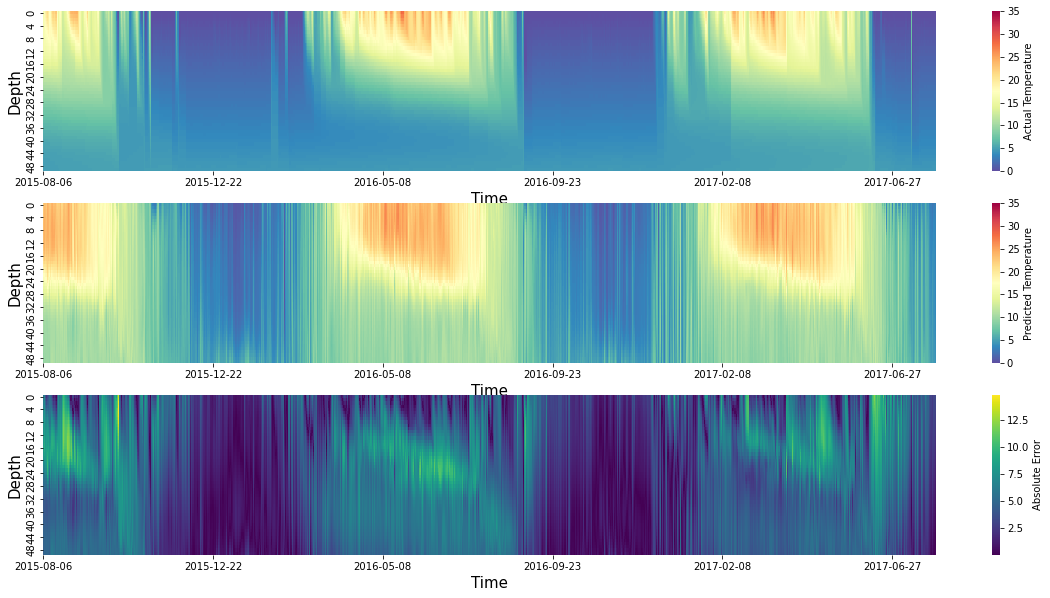

In [34]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

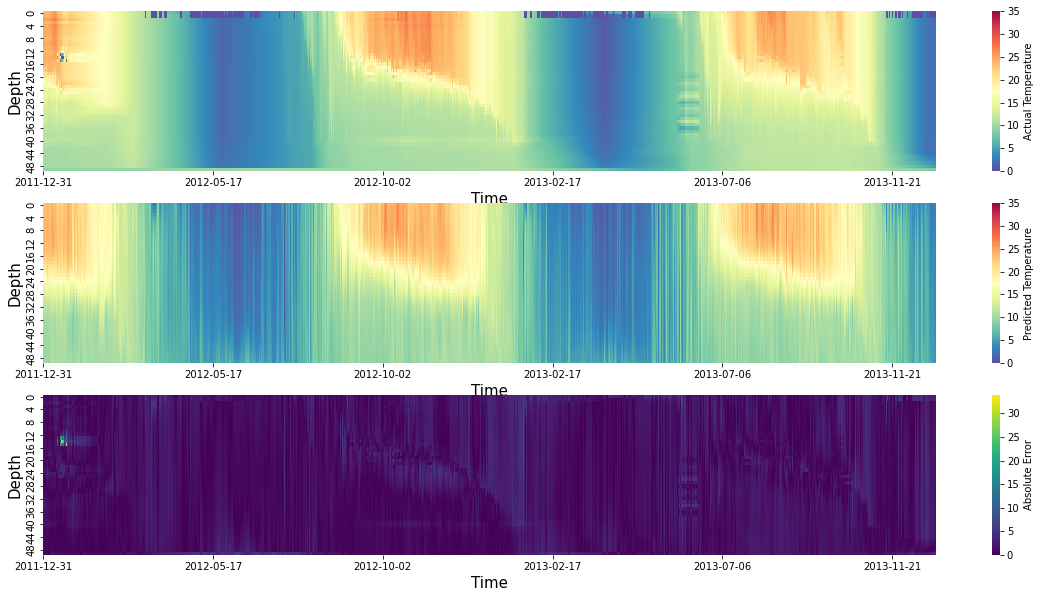

In [35]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

## Mixing Model

## Convection Model

## Ice Model

# Compute Model Similarity after Finetuning

In [36]:
# Freeze all models again and compute finetuned diffusivity values

In [37]:
# Unfreeze diffusion model and finetune it on projected diffusivities

In [38]:
PATH = f"./saved_models/directdeep_model_finetuned.pth"
torch.save(direct_model.state_dict(), PATH)